# Neural Networks for Data Science Applications
## Second Homework: Experimenting with continual learning

**Name**: *Iliyas Bektas*

**Matricola**: *1971117*

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (19/01/2022), the final deadline is **17/01/2022 at 23:59**.

**Overview**: The homework is composed of four parts: (i) selecting a dataset; (ii) implementing a custom component (ONLY if you did not submit the first homework or if you want to improve your mark); (iii) implementing a neural network and training it on the dataset; (iv) implementing an additional continual learning strategy on top of it.

> 🟨 **Important - before starting**: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*.

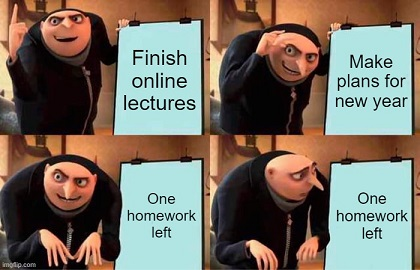

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Try not to use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

**DESCRIPTION OF THE CODE**: 
In recent years, handwritten digits recognition has been an important area due to its applications in several fields. This dataset is a collection of handwritten Arabic digits recognition that face several challenges, including the unlimited variation in human handwriting and the large public databases. It contains 60000 training and 10000 testing images. I downloaded the dataset from Kaggle.

### 0.Data Exploration Preprocessing
Since the dataset is given in csv. format, I have to do the cleaning, basic preprocessing and transform it into the format that would allow me to build the model.

In [52]:
from google.colab import drive
drive.mount('/content/drive')
main_path = "/content/drive/MyDrive/Colab_Notebooks/Sapienza/NNDS/Continual_learning/main_project/ara_digits_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [54]:
# Get the data and labels
train_data = pd.read_csv( main_path +"csvTrainImages 60k x 784.csv")
test_data = pd.read_csv(main_path +"csvTestImages 10k x 784.csv")
train_label = pd.read_csv(main_path +"csvTrainLabel 60k x 1.csv")
test_label = pd.read_csv(main_path +"csvTestLabel 10k x 1.csv")

In [55]:
# During the analysis, I noticed that the dataset goes in order like 0,1,2... 9, 0, 1. Thus, I shuffle it beforehand. 
df_train = pd.merge(train_data, train_label, left_index=True, right_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = pd.merge(test_data, test_label, left_index=True, right_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
train_data = df_train.loc[ : , df_train.columns != '0_y']
train_label = df_train[['0_y']]
test_data = df_test.loc[ : , df_test.columns != '0_y']
test_label = df_test[['0_y']]

#### Data Exploration:

In [56]:
# Let's take a look at the shape of the data
train_data.shape

(59999, 784)

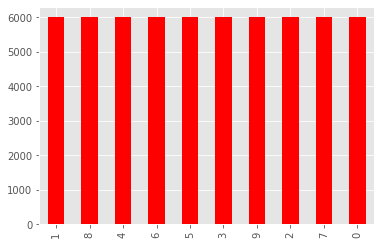

In [57]:
# Let's look at the label's distribution
train_label.iloc[:, 0].value_counts().plot(cmap = "autumn", kind = "bar")

* We could see that the labels are distributed equally. This means that we could use accuracy for our evaluation metrics.
* We could also use Precision, Recall, F1-scores.

In [58]:
# Let's first convert the data to numpy array for better array manipulation:
x_train = train_data.to_numpy()
x_test = test_data.to_numpy()
y_train = train_label.to_numpy()
y_test  = test_label.to_numpy()

In [59]:
# We change the shape for the implementation in the model
x_train = x_train.reshape(x_train.shape[0], 28, 28)
x_test = x_test.reshape(x_test.shape[0], 28, 28)
y_train = y_train.reshape(y_train.shape[0], )
y_test = y_test.reshape(y_test.shape[0], )
x_train.shape

(59999, 28, 28)

In [60]:
# Some further processing like normalization and changing to a float datatype
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test/= 255

#### It looks like the numbers are flipped and inverted. Let's do a transpose to the numpy array to see if it gets any better

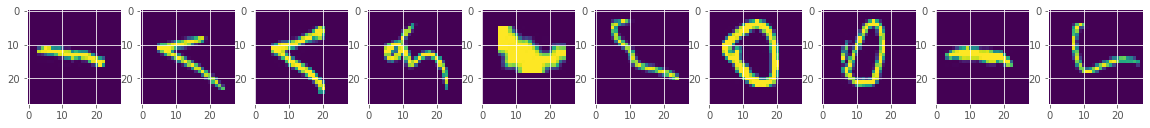

In [61]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i])

#### Let's transpose all the data:

In [62]:
x_train = np.array([element.transpose() for element in x_train])
x_test = np.array([element.transpose() for element in x_test])

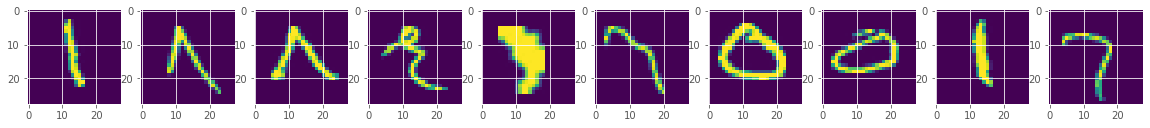

In [63]:
fig, ax = plt.subplots(1,10, figsize = (20,20))
for i in range(10):
    ax[i].imshow(x_train[i])

#### Finally, we can change our data to BatchDataset format

In [64]:
train_A = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(32)
test_A = (x_test, y_test)

### Exercise 2: Train on your data (4 points)

#### Choose of the hyperparameters:

In [65]:
epochs = 7
lambda_ = 0.1 
lr = 0.001
num_sample = 30
opt = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#### I decided to use regular multilayer perceptron since the data is not computationally heavy as well as due to this model's high level of performance.
Also, there are some methods within the classes which even though are not used in this part, they are going to be used for the implementation of the Elastic Weight Consolidation for the next section. 

In [66]:
# Simple multi-layer perceptron 
class MLP3:
    
    def __init__(self, input_shape=(28, 28), hidden_layers_neuron_list=[200, 200], num_classes=10):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.hidden_layers_neuron_list = hidden_layers_neuron_list
        self.model = self.create_mlp()
        
    def create_mlp(self):
        model = Sequential([
                Flatten(input_shape=self.input_shape),
                Dense(self.hidden_layers_neuron_list[0], input_shape=self.input_shape, activation='relu'),
                Dense(self.hidden_layers_neuron_list[1], activation='relu'),
                Dense(self.num_classes)
        ])
        return model
    
    def get_uncompiled_model(self):
        return self.model
    
    def get_compiled_model(self, optimizer, loss_fn, metrics ):
        compiled_model = self.model
        compiled_model.compile(optimizer, loss_fn, metrics)
        return compiled_model


In [67]:
def evaluate(model, test_x, test_y):
    acc = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
    for imgs, labels in zip(test_x, test_y):
        preds = model.predict_on_batch(np.array([imgs]))
        acc.update_state(labels, preds)
    return round(100*acc.result().numpy(), 2)

In [68]:
class Train:
    
    def __init__(self, optimizer, loss_fn, prior_weights=None, lambda_=0.1):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.prior_weights = prior_weights
        self.lambda_ = lambda_
        
    def train(self, model, epochs, train_task, fisher_matrix=None, test_tasks=None):
        # empty list to collect per epoch test acc of each task
        if test_tasks:
            test_acc = [[] for _ in test_tasks]
        else: 
            test_acc = None
        for epoch in tqdm(range(epochs)):
            for batch in train_task:
                X, y = batch
                with tf.GradientTape() as tape:
                    pred = model(X)
                    loss = self.loss_fn(y, pred)
                    # for the later implementation in the EWC
                    if fisher_matrix is not None:
                        loss += self.compute_penalty_loss(model, fisher_matrix)
                grads = tape.gradient(loss, model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
            # evaluate with the test set of task after each epoch
            if test_acc:
                for i in range(len(test_tasks)):
                    test_acc[i].append(evaluate(model, test_tasks[i][0], test_tasks[i][1]))
        return test_acc
    # Generate a loss function which will penalise divergence from the current
    # state. It is assumed that the model achieves good accuracy on `dataset`,
    # and we want to preserve this behaviour.
    # The penalty is scaled according to how important each weight is for the
    # given dataset, and `lambda applies equally to all weights.
    def compute_penalty_loss(self, model, fisher_matrix):
        penalty = 0.
        for u, v, w in zip(fisher_matrix, model.weights, self.prior_weights):
            penalty += tf.math.reduce_sum(u * tf.math.square(v - w))
        return 0.5 * self.lambda_ * penalty


In [69]:
mlp = MLP3()
trn_gd = Train(opt, loss_fn)
model1 = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])

acc11 = trn_gd.train(model1, epochs, train_A, test_tasks=[test_A])[0]
model1.save('arabic.h5')
print('[INFO] Task A Original (SGD): {}'.format(acc11[-1]))

100%|██████████| 7/7 [08:14<00:00, 70.70s/it]

[INFO] Task A Original (SGD): 98.39


#### We see a really high test accuracy after 35 epochs though 97 % accuracy took place within first few epochs. It might give a sense that few epochs are enough for the training but I wanted the model to really memorize the whole dataset to make sure that it would be robust to the new tasks even when using Vanilla SGD method

### Exercise 3 (6 points): Continual learning

In the third part of the homework, you are asked to implement a continual learning setup with the following characteristics: 

* **Task-incremental learning**: split the dataset in > 2 task (e.g., dividing the outputs into disjoint subsets). The model will be a multi-head model, similar to what we saw in the slides.
* Train the model on the tasks sequentially, using **elastic weight consolidation** (EWC).
* Show at least the mean accuracy (as defined in the slides) and the backward transfer after training. You can also show some *performance graphs* similar to the ones from the slides (with the id of the task on the x-axis).

🟩 **Please do:**

1. Carefully read [this guide](https://www.tensorflow.org/guide/keras/train_and_evaluate) from the TensorFlow website. You can implement EWC in several ways.
2. It would be preferable to implement the accuracy and the backward transfer by subclassing `tf.keras.metrics.Metric`.
3. Comment the code and provide a complete description below.

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

#### 3.1. Task-incremental learning:
 For this task, instead of splitting the dataset, I decided to permute the dataset as if it is coming from the other distribution (the same idea as in "Overcoming catastrophic forgetting in neural
networks" paper applied to mnist dataset). I know that it is different from the instructions but this way I believe we are getting more realistic scenario and we do not need to create a lot of tasks since after the permutation the new task would be as large as the whole dataset.

In [70]:
# Permute pixels of image data. The same permutation is applied to all images. 
# Also, I added the seed to generation of other tasks and for the reprodicibility
def permute_task(train, test, seed):
    seed = seed
    np.random.seed(seed) # for reproducibility. If we want to create new tasks
    train_shape, test_shape = train.shape, test.shape
    train_flat, test_flat = train.reshape((-1, 784)), test.reshape((-1, 784))
    idx = np.arange(train_flat.shape[1])
    np.random.shuffle(idx)
    train_permuted, test_permuted = train_flat[:, idx], test_flat[:, idx]
    return (train_permuted.reshape(train_shape), test_permuted.reshape(test_shape))

In [71]:
# Applying pixel permutation
x_train_B, x_test_B = permute_task(x_train, x_test, 1)
y_train_B, y_test_B = y_train, y_test
 
train_B = tf.data.Dataset.from_tensor_slices((x_train_B, y_train_B)).shuffle(1000).batch(32)
test_B = (x_test_B, y_test_B)

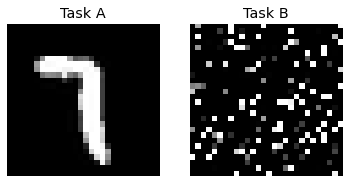

In [72]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[200], cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train_B[200], cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()

#### 3.2. Train the model on the tasks sequentially, using elastic weight consolidation (EWC).

 Initially we train the orginal model on the new task using EWC and then we train by applying Vanilla SGD. We will see that training with EWC gives us a better accuracy.

In [73]:
class EWC:
    
    def __init__(self, prior_model, data_samples, num_sample=30):
        self.prior_model = prior_model
        self.prior_weights = prior_model.weights
        self.num_sample = num_sample
        self.data_samples = data_samples
        self.fisher_matrix = self.compute_fisher()
  

    # Computing the Fisher matrix, representing the importance of each weight in the
    # model. This is approximated using the variance of the gradient of each
    # weight, for some number of samples from the dataset.
    def compute_fisher(self):
        weights = self.prior_weights
        fisher_accum = np.array([np.zeros(layer.numpy().shape) for layer in weights], 
                           dtype=object
                          )
        for j in tqdm(range(self.num_sample)):
            idx = np.random.randint(self.data_samples.shape[0])
            with tf.GradientTape() as tape:
                logits = tf.nn.log_softmax(self.prior_model(np.array([self.data_samples[idx]])))
            grads = tape.gradient(logits, weights)
            for m in range(len(weights)):
                fisher_accum[m] += np.square(grads[m])
        fisher_accum /= self.num_sample
        return fisher_accum
    
    def get_fisher(self):
        return self.fisher_matrix
    

Firstly, we construct the fisher matrix using samples from task A

In [74]:
ewc = EWC(model1, x_train, num_sample=num_sample)
f_matrix = ewc.get_fisher()

100%|██████████| 30/30 [00:00<00:00, 264.16it/s]


**Training task B with EWC - using the computed Fisher matrix from task A and the prior weights obtained from A**

In [75]:
model2 = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model2.load_weights('arabic.h5') 
prior_weights = model2.get_weights()

In [76]:
trn = Train(opt, loss_fn, prior_weights=prior_weights, lambda_=lambda_)
acc12, acc22 = trn.train(model2, 
                     epochs, 
                     train_B, 
                     fisher_matrix=f_matrix, 
                     test_tasks=[test_A, test_B]
                    )

print('[INFO] Task A ACC. after training B with EWC: {}'.format(acc12[-1]))
print('[INFO] Task B ACC. after training B with EWC: {}'.format(acc22[-1]))

100%|██████████| 7/7 [16:45<00:00, 143.69s/it]

[INFO] Task A ACC. after training B with EWC: 98.19
[INFO] Task B ACC. after training B with EWC: 97.93


**Training task B with vannila SGD**

In [77]:
model_sgdB = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model_sgdB.load_weights('arabic.h5')
acc_sgdA, acc_sgdB = trn_gd.train(model_sgdB, 1, train_B, test_tasks = [test_A, test_B])

print('[INFO] Task A ACC. after training B with GD: {}'.format(acc_sgdA[-1]))
print('[INFO] Task B ACC. after training B with GD: {}'.format(acc_sgdB[-1]))

100%|██████████| 1/1 [02:02<00:00, 122.21s/it]

[INFO] Task A ACC. after training B with GD: 90.86
[INFO] Task B ACC. after training B with GD: 97.85


We can see that by applying Elastic Weight Consolidation we are able to retain higher test accuracy of the task A.  

#### Bar Plots

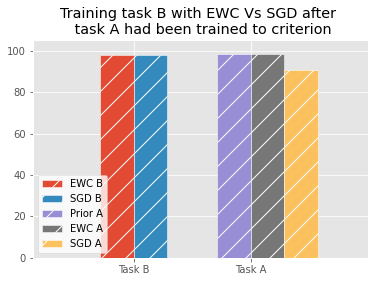

In [78]:
x = 0
total_width, n = 0.1, 2
width = total_width / n
x = x - (total_width - width) / 2
plt.style.use('ggplot')
plt.bar(x, acc22[-1], width=width, label='EWC B', hatch='w/', ec='w')
plt.bar(x + width, acc_sgdB[-1], width=width, label='SGD B', hatch='w/', ec='w')
plt.bar(x + 3.5 * width, acc11[-1], width=width, label='Prior A', hatch='w/', ec='w')
plt.bar(x + 4.5 * width, acc12[-1], width=width, label='EWC A', hatch='w/', ec='w')
plt.bar(x + 5.5 * width, acc_sgdA[-1], width=width, label='SGD A', hatch='w/', ec='w')
plt.legend(facecolor='white', loc='lower left')
plt.xticks(np.array([0., 3.5 * width]), ('Task B', 'Task A'))
plt.title('Training task B with EWC Vs SGD after \n task A had been trained to criterion')
plt.xlim(-0.15, 0.35)
plt.ylim(0., 105.)
plt.show()

Text(0.5, 0, 'Epochs')

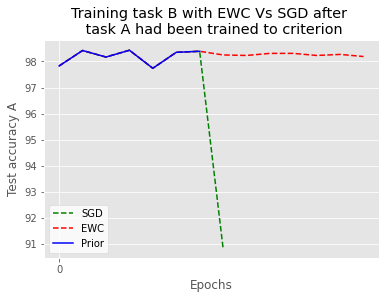

In [79]:
plt.plot(range(0, epochs + 1, 1), (acc11 + acc_sgdA), color='green', linestyle='dashed', label = "SGD")
plt.plot(range(0, epochs*2, 1), (acc11 + acc12), color='red', linestyle='dashed', label = "EWC")
plt.plot(range(0, epochs, 1), (acc11), color='blue', label = "Prior")
#plt.axvline(x=9, linestyle='dashed', color='green')
plt.xticks(range(0, epochs*2, 50))
plt.title('Training task B with EWC Vs SGD after \n task A had been trained to criterion')
plt.legend(facecolor='white')
plt.ylabel('Test accuracy A')
plt.xlabel('Epochs')

#### Task C
In this section, the logic is the same as in the previous section except that in this case we are using the weights of the model trained with task B using the EWC. 

In [80]:
x_train_C, x_test_C = permute_task(x_train, x_test, 2)
y_train_C, y_test_C = y_train, y_test
 
train_C = tf.data.Dataset.from_tensor_slices((x_train_C, y_train_C)).shuffle(1000).batch(32)
test_C = (x_test_C, y_test_C)

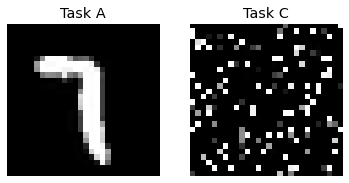

In [81]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[200], cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train_C[200], cmap='gray')
plt.title('Task C')
plt.axis('off')
plt.show()

**Training task C with EWC - using the computed Fisher matrix from task B trained with EWC and the prior weights obtained from there**

In [82]:
model2.save('arabic_ewcB.h5')

In [83]:
ewc = EWC(model2, x_train_B, num_sample=num_sample)
f_matrix = ewc.get_fisher()
model3 = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model3.load_weights('arabic_ewcB.h5') 
prior_weights = model3.get_weights()

100%|██████████| 30/30 [00:00<00:00, 263.18it/s]


In [84]:
trn = Train(opt, loss_fn, prior_weights=prior_weights, lambda_=lambda_)
acc13, acc23, acc33 = trn.train(model3, 
                     epochs, 
                     train_C, 
                     fisher_matrix=f_matrix, 
                     test_tasks=[test_A, test_B, test_C]
                    )


print('[INFO] Task B ACC. after training C with EWC: {}'.format(acc23[-1]))
print('[INFO] Task C ACC. after training C with EWC: {}'.format(acc33[-1]))

100%|██████████| 7/7 [22:24<00:00, 192.11s/it]

[INFO] Task B ACC. after training C with EWC: 97.4
[INFO] Task C ACC. after training C with EWC: 98.14


**Training task C with vannila SGD**

In [85]:
model_sgdC = mlp.get_compiled_model(opt, loss_fn, ['accuracy'])
model_sgdC.load_weights('arabic_ewcB.h5')
acc_sgdB_new, acc_sgdC = trn_gd.train(model_sgdB, 1, train_C, test_tasks = [test_B, test_C])

print('[INFO] Task B ACC. after training C with GD: {}'.format(acc_sgdB[-1]))
print('[INFO] Task C ACC. after training C with GD: {}'.format(acc_sgdC[-1]))

100%|██████████| 1/1 [02:02<00:00, 122.32s/it]

[INFO] Task B ACC. after training C with GD: 97.85
[INFO] Task C ACC. after training C with GD: 97.87


Text(0.5, 0, 'Epochs')

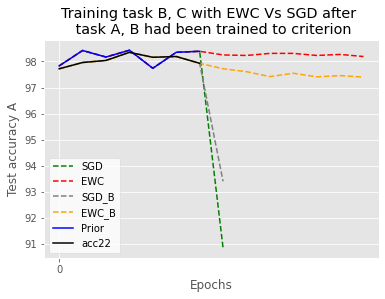

In [94]:
plt.plot(range(0, epochs+1, 1), (acc11 + acc_sgdA), color='green', linestyle='dashed', label = "SGD")
plt.plot(range(0, epochs*2, 1), (acc11 + acc12), color='red', linestyle='dashed', label = "EWC")
plt.plot(range(0, 8, 1), (acc22 + acc_sgdB_new), color='grey', linestyle='dashed', label = "SGD_B")
plt.plot(range(0, epochs*2, 1), (acc22 + acc23), color='orange', linestyle='dashed', label = "EWC_B")
plt.plot(range(0, epochs, 1), (acc11), color='blue', label = "Prior")
plt.plot(range(0, epochs, 1), (acc22), color='black', label = "acc22")

#plt.axvline(x=9, linestyle='dashed', color='green')
plt.xticks(range(0, epochs*2, 50))
plt.title('Training task B, C with EWC Vs SGD after \n task A, B had been trained to criterion')
plt.legend(facecolor='white')
plt.ylabel('Test accuracy A')
plt.xlabel('Epochs')

### Metrics for Continual Learning
#### Global Accuracy





After observing t different task, the performance of the model can be summarized in a R(t,t) matrix, where Ri,j is the performance on task i after training on task j.
Several CL metrics can be obtained from this matrix. For example, a global
accuracy.

In [87]:
global_accuracy = (acc11[-1] + acc12[-1]+ acc13[-1] + acc22[-1] + acc23[-1] + acc33[-1])/6
print('[INFO] Global Accuracy: {}'.format(round(global_accuracy,2)))

[INFO] Global Accuracy: 93.65


#### Backward Transfer 

Another interesting metric is backward transfer, i.e., how much training on
a new task has improved or worsened the previous tasks:

In [88]:
backward_transfer = ((acc12[-1] -  acc11[-1]) + (acc13[-1] -  acc11[-1]) +  (acc23[-1] -  acc22[-1]))/3
print('[INFO] Backward Transfer: {}'.format(round(backward_transfer, 2)))

[INFO] Backward Transfer: -9.09
